In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [2]:
df_conflits = pd.read_csv("data/brazil_conflicts_dataset.csv")  
df_conflits.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 8331 entries, 279975 to 485414
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8331 non-null   object 
 1   relid              8331 non-null   int64  
 2   year               8331 non-null   bool   
 3   active_year        8331 non-null   object 
 4   code_status        8331 non-null   int64  
 5   type_of_violence   8331 non-null   int64  
 6   conflict_dset_id   8331 non-null   int64  
 7   conflict_new_id    8331 non-null   object 
 8   conflict_name      8331 non-null   int64  
 9   dyad_dset_id       8331 non-null   int64  
 10  dyad_new_id        8331 non-null   object 
 11  dyad_name          8331 non-null   int64  
 12  side_a_dset_id     8331 non-null   int64  
 13  side_a_new_id      8331 non-null   object 
 14  side_a             8331 non-null   int64  
 15  side_b_dset_id     8331 non-null   int64  
 16  side_b_new_id      833

In [3]:
df_conflits.head()

,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best_est,high_est,low_est
279975,BRA-2018-2-15489-47,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,11/01/2018 00:00:00,11/30/2018 00:00:00,0,0,0,9,9,9,9,NaN
279977,BRA-2018-2-15489-48,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,12/01/2018 00:00:00,12/13/2018 00:00:00,0,0,0,6,6,6,6,NaN
279979,BRA-2018-2-15489-49,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,12/12/2018 00:00:00,12/12/2018 00:00:00,0,0,0,2,2,2,2,NaN
279980,BRA-2018-2-15489-50,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,12/05/2018 00:00:00,12/05/2018 00:00:00,0,0,1,0,1,1,1,NaN
279982,BRA-2018-2-15489-59,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,12/05/2018 00:00:00,12/06/2018 00:00:00,0,0,0,3,3,3,3,NaN


## Limpeza de dados

In [10]:
features_numericas = ['year', 'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best_est', 'high_est']

In [11]:
# Criando um df para que tudo seja float
df_num_limpo = df_conflits[features_numericas].apply(pd.to_numeric, errors='coerce').fillna(0)

In [13]:
# Convertendo para string antes do get_dummies para garantir que o pandas consiga tratar como categorias nominais e não como numeros ordiários
df_cat_limpo = pd.get_dummies(df_conflits[['type_of_violence', 'active_year']].astype(str), prefix='cat', drop_first=True)

In [16]:
# Criando o DataFrame de modelagem concatenando por colunas
df_model = pd.concat([df_num_limpo, df_cat_limpo], axis=1)

In [19]:
# Escalonamento dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

X_scaled.shape

(8331, 40)

## Redução de dimensionalidade - PCA


In [21]:
from sklearn.decomposition import PCA

In [23]:
# Inicializando a PCA sem redução para analisar um panorama inicial
pca_full = PCA()
pca_full.fit(X_scaled)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",None
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized S

In [24]:
# Calculando a variancia explicada acumulada
variancia_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

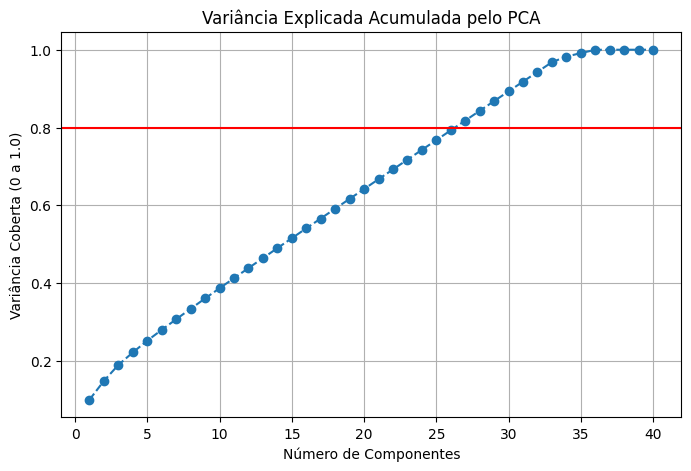

Variância com 2 componentes: 14.87%


In [25]:
# Visualização
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='-') # Linha de corte de 80%
plt.title('Variância Explicada Acumulada pelo PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Coberta (0 a 1.0)')
plt.grid()
plt.show()

print(f"Variância com 2 componentes: {variancia_acumulada[1]:.2%}")

A análise de variância explicada desmonstrou que os dados de conflitos no Brasil são altamente complexos e não se resumem a poucos fatores.
Isso pode ser facilmente visto pelo gráico acima, no qual, foram necessários mais de 25 componentes para cbrir 80% da variância total, indicando 
que a violência é um fenomeno multifacetado.

## Redução de dimensionalidade - t-SNE e UMAP

In [27]:
from sklearn.manifold import TSNE 
import umap

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

In [29]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


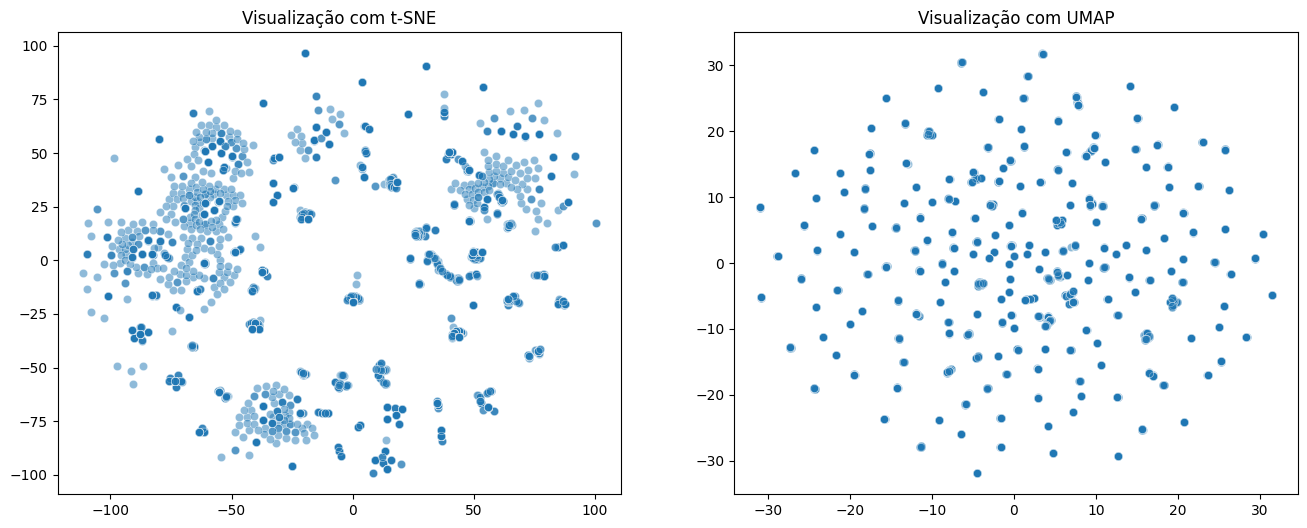

In [30]:
# Visualização Lado a Lado
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], ax=ax[0], alpha=0.5)
ax[0].set_title('Visualização com t-SNE')

sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], ax=ax[1], alpha=0.5)
ax[1].set_title('Visualização com UMAP')

plt.show()

Enquanto o UMAP mostrou uma visão mais global e compacta, o t-SNE foi fundamental para revelar a estrutura granular dos dados. Ele expôs "ilhas" distintas de eventos que serviram de base para a validação dos algoritmos de clusterização.

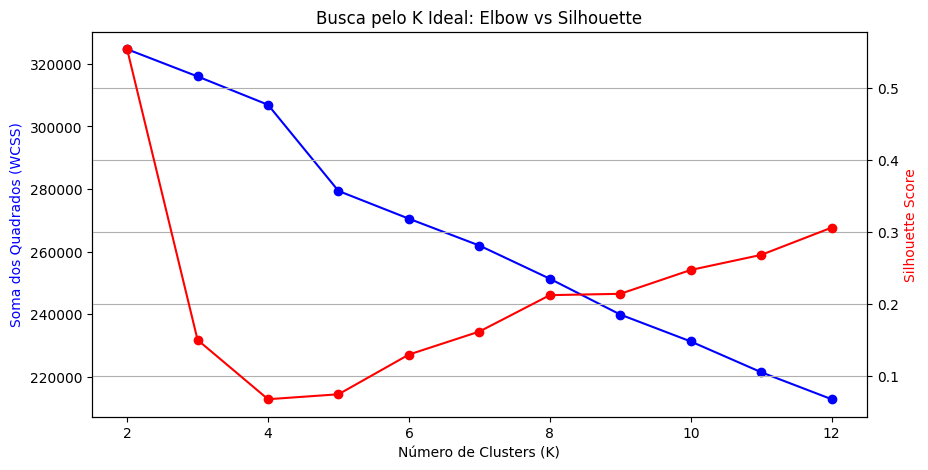

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Testando valores de K de 2 a 12
wcss = []
silhouette_values = []
K_range = range(2, 13)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X_scaled) # Usamos os dados escalonados!
    
    wcss.append(kmeans.inertia_)
    silhouette_values.append(silhouette_score(X_scaled, labels))

# Plotando os resultados
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(K_range, wcss, 'bo-', label='WCSS (Elbow)')
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('Soma dos Quadrados (WCSS)', color='b')

ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_values, 'ro-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')

plt.title('Busca pelo K Ideal: Elbow vs Silhouette')
plt.grid()
plt.show()

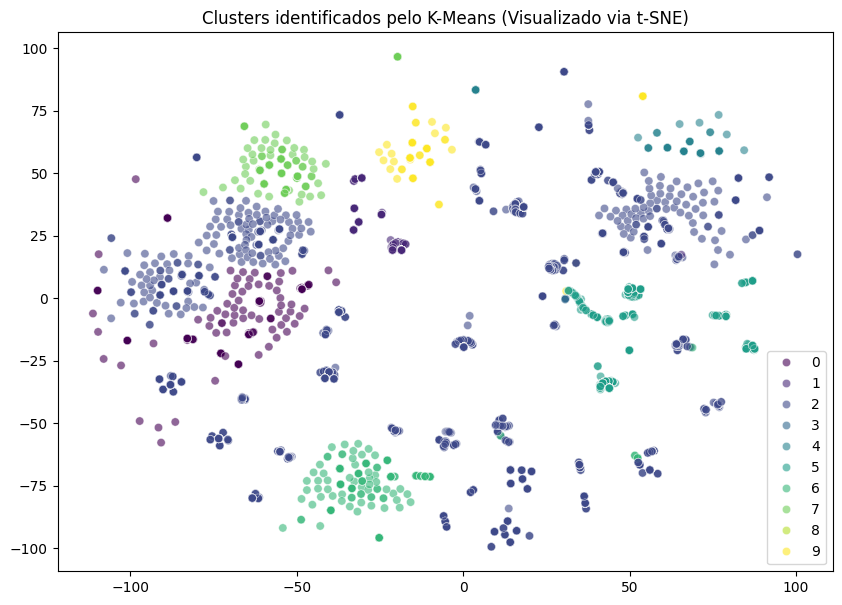

In [41]:
# Executando o K-means com o K escolhido
kmeans_final = KMeans(n_clusters=10, init='k-means++', random_state=42)
clusters = kmeans_final.fit_predict(X_scaled)

# Adicionando o resultado ao seu DataFrame para análise futura
df_model['cluster_kmeans'] = clusters

# Visualizando o resultado no mapa do t-SNE
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters, palette='viridis', legend='full', alpha=0.6)
plt.title('Clusters identificados pelo K-Means (Visualizado via t-SNE)')
plt.show()

In [37]:
# Agrupando os dados originais pelos clusters do K-means para ver as médias
analise_clusters = df_model.groupby('cluster_kmeans')[features_numericas].mean()

# Exibindo a tabela (Arredondada para facilitar a leitura)
print("Perfil Estatístico dos Clusters:")
display(analise_clusters.round(2))

Perfil Estatístico dos Clusters:


,year,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best_est,high_est
cluster_kmeans,,,,,,,
0,0.93,0.12,0.10,0.98,1.33,1.33,1.33
1,1.00,0.02,0.03,0.99,1.07,1.09,1.07
2,0.91,0.08,0.12,1.08,1.34,1.37,1.33
3,1.00,0.00,0.00,1171.20,1171.20,1143.40,1171.20
4,1.00,0.01,0.03,1.09,1.13,1.13,1.13
5,1.00,0.08,0.05,3.98,4.17,4.31,4.17
6,0.84,0.00,1.38,0.09,1.47,1.60,1.42
7,0.99,0.05,0.06,0.93,1.10,1.17,1.10
8,1.00,62.00,0.00,0.00,62.00,62.00,62.00


O uso do K-Means com K=10 permitiu criar uma tipologia clara dos conflitos:

- Conflitos de Letalidade Extrema (Cluster 3): Eventos raros mas devastadores, com média superior a 1.171 mortes civis por ocorrência.

- Conflitos Táticos/Operacionais (Cluster 8): Caracterizados por baixas exclusivas entre combatentes (média de 62 mortes em deaths_a) e zero fatalidades civis.

- Violência Endêmica (Demais Clusters): A grande massa de dados reflete conflitos de baixa intensidade e alta frequência espalhados pelo território.

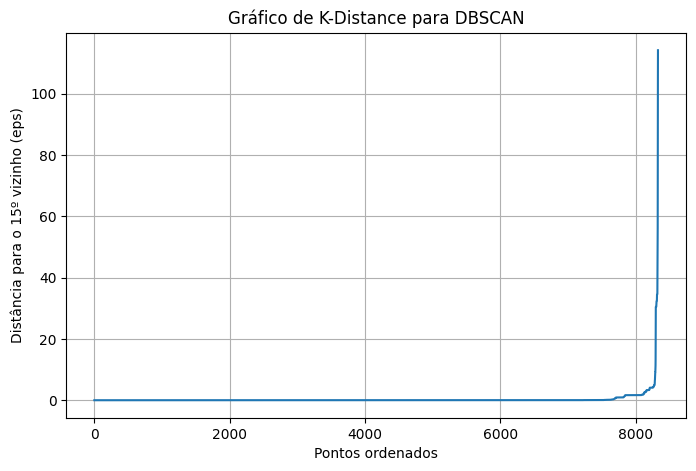

In [40]:
from sklearn.neighbors import NearestNeighbors

# Para DBSCAN, uma regra prática é usar min_samples = 2 * dimensões
# Como temos muitas colunas, vamos fixar min_samples=15 para evitar micro-clusters
min_samples = 15

# Calculando as distâncias para o 15º vizinho mais próximo
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Ordenando as distâncias para o gráfico
distances = np.sort(distances[:, min_samples-1], axis=0)

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('Gráfico de K-Distance para DBSCAN')
plt.xlabel('Pontos ordenados')
plt.ylabel(f'Distância para o {min_samples}º vizinho (eps)')
plt.grid()
plt.show()

In [36]:
from sklearn.cluster import DBSCAN

# Tentando um eps baseado no início da subida do seu gráfico
# Ajuste este valor se o número de ruídos (-1) for muito alto (ex: > 50%)
dbscan = DBSCAN(eps=5.0, min_samples=15)
db_clusters = dbscan.fit_predict(X_scaled)

# Adicionando ao DataFrame
df_model['cluster_dbscan'] = db_clusters

# Verificando quantos clusters foram criados e quantos ruídos
print(f"Clusters DBSCAN encontrados: {len(set(db_clusters)) - (1 if -1 in db_clusters else 0)}")
print(f"Pontos considerados ruído: {list(db_clusters).count(-1)}")

Clusters DBSCAN encontrados: 23
Pontos considerados ruído: 41


O DBSCAN validou a densidade dos grupos, encontrando 23 micro-clusters densos e apenas 41 pontos de ruído, o que prova que os eventos de conflito no Brasil não são aleatórios, mas seguem padrões repetitivos de comportamento.

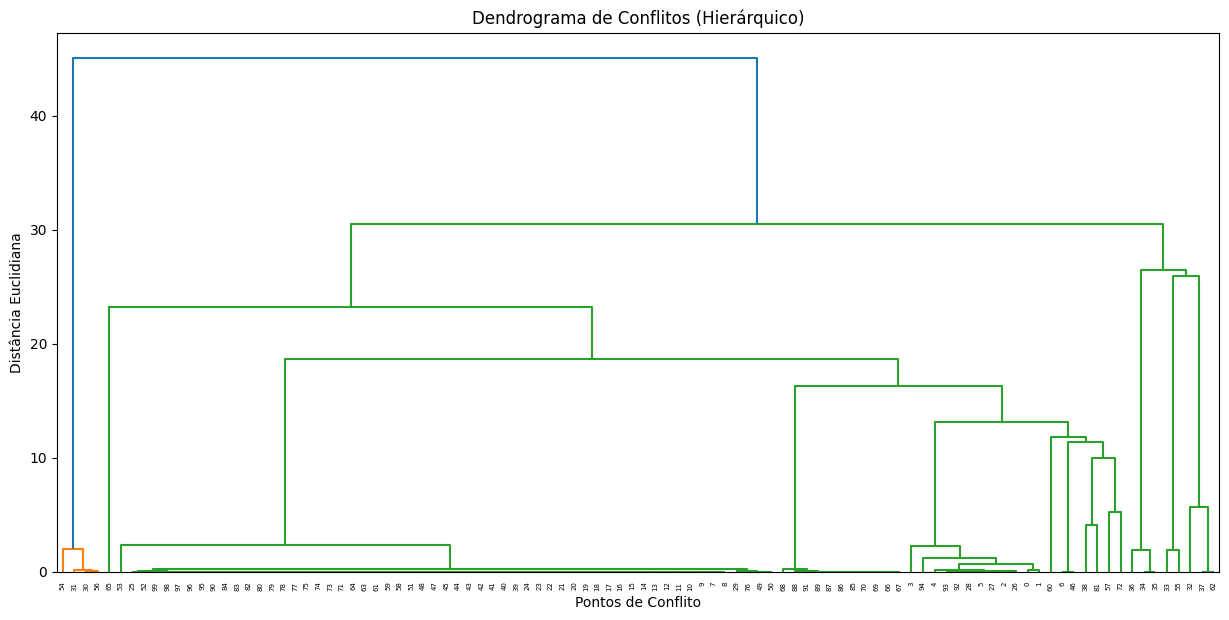

In [61]:

import scipy.cluster.hierarchy as sch

plt.figure(figsize=(15, 7))
plt.title("Dendrograma de Conflitos (Hierárquico)")

# Usando o método de Ward para minimizar a variância dentro dos grupos
# Pegamos uma amostra de 100 pontos apenas para o gráfico ficar legível
dendrogram = sch.dendrogram(sch.linkage(X_scaled[:100], method='ward'))

plt.xlabel("Pontos de Conflito")
plt.ylabel("Distância Euclidiana")
plt.show()

O Dendrograma revelou a hierarquia dessa violência, mostrando como pequenos grupos de conflitos locais se fundem em padrões regionais maiores à medida que aumentamos a distância de similaridade.

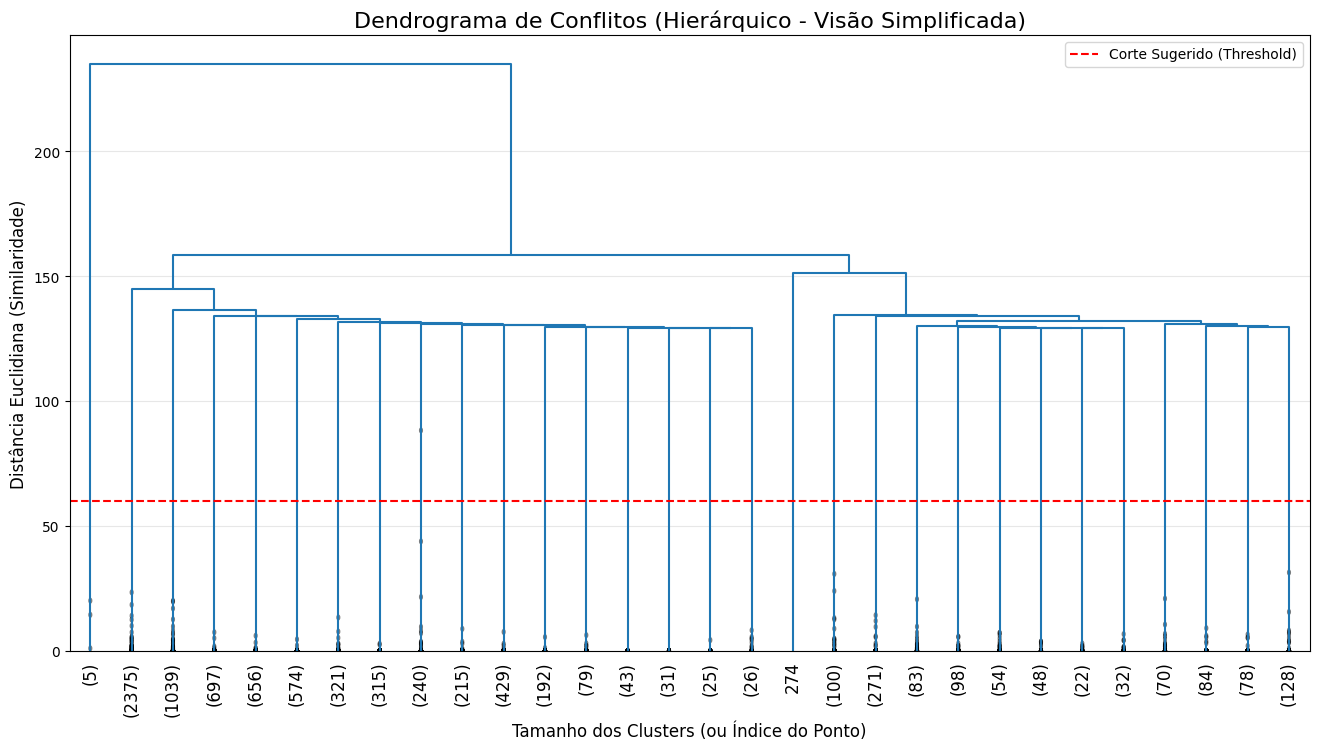

In [54]:
plt.figure(figsize=(16, 8))

# Gerando o Linkage (se ainda não tiver feito)
Z = sch.linkage(X_scaled, method='ward')

# Plotando com Truncamento
# 'lastp' mostra apenas os últimos p nós fundidos
# 'level' ajuda a controlar a profundidade visual
dendro = sch.dendrogram(
    Z, 
    truncate_mode='lastp', 
    p=30,                  # Mostra apenas os 30 clusters finais
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # Mostra as marcas de onde a árvore foi "podada"
    color_threshold=60     # Define a cor baseada na distância (ajuste conforme necessário)
)

# Adicionando uma linha de corte (Threshold)
# Essa linha ajuda a justificar por que você escolheu 10 clusters no K-means
plt.axhline(y=60, color='r', linestyle='--', label='Corte Sugerido (Threshold)')

plt.title('Dendrograma de Conflitos (Hierárquico - Visão Simplificada)', fontsize=16)
plt.xlabel('Tamanho dos Clusters (ou Índice do Ponto)', fontsize=12)
plt.ylabel('Distância Euclidiana (Similaridade)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

<Figure size 1400x800 with 0 Axes>

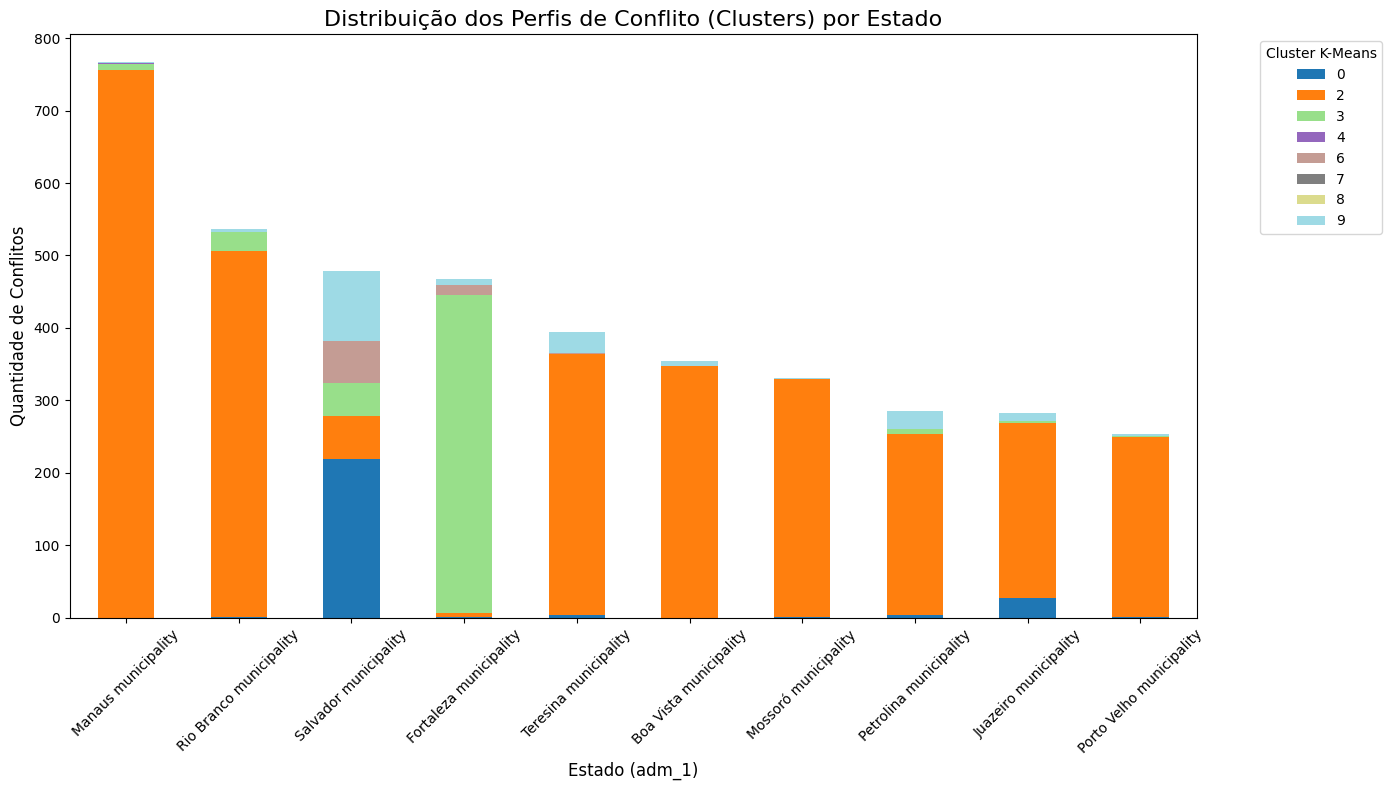

Estados com maior incidência do Cluster 3 (Alta Letalidade Civil):
adm_1
Fortaleza municipality     440
Caucaia municipality       200
Salvador municipality       45
Maracanaú municipality      42
Maranguape municipality     38
Name: 3, dtype: int64


In [55]:
# Criando a tabela de cruzamento (Crosstab)
# Isso conta quantos eventos de cada cluster aconteceram em cada estado
ct = pd.crosstab(df_conflits.loc[df_model.index, 'adm_1'], df_model['cluster_kmeans'])

# Filtrando os top 10 estados com mais conflitos para o gráfico não poluir
top_10_estados = ct.sum(axis=1).sort_values(ascending=False).head(10).index
ct_plot = ct.loc[top_10_estados]

# Plotando o gráfico de barras empilhadas
plt.figure(figsize=(14, 8))
ct_plot.plot(kind='bar', stacked=True, colormap='tab20', figsize=(14, 8))

plt.title('Distribuição dos Perfis de Conflito (Clusters) por Estado', fontsize=16)
plt.xlabel('Estado (adm_1)', fontsize=12)
plt.ylabel('Quantidade de Conflitos', fontsize=12)
plt.legend(title='Cluster K-Means', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Exibindo os estados onde o Cluster 3 (o mais letal) é mais frequente
print("Estados com maior incidência do Cluster 3 (Alta Letalidade Civil):")
print(ct[3].sort_values(ascending=False).head(5))